In [228]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
DATA_DIR = 'data/'
pd.set_option('display.max_colwidth', None) #Print full text
pd.set_option('display.max_rows', 1000) #Print full text

### 1.Merge input files into one large census file (run once)

In [55]:
files = os.listdir(DATA_DIR)
census_files = [file for file in files if '.xlsx' in file]

df_example = pd.read_excel(DATA_DIR+'1810.xlsx', index_col=0)

df_census = pd.DataFrame(columns=df_example.columns)
for filename in census_files:
    file_year = filename.replace('.xlsx','')
    df_year = pd.read_excel(DATA_DIR+filename, index_col=0)
    df_year['annee'] = file_year
    df_census = df_census.append(df_year)
    print(f'Merged census file {filename}')
    
print(df_census.columns)

Merged census file 1861.xlsx
Merged census file 1836.xlsx
Merged census file 1898.xlsx
Merged census file 1877.xlsx
Merged census file 1882.xlsx
Merged census file 1894.xlsx
Merged census file 1857.xlsx
Merged census file 1841.xlsx
Merged census file 1840.xlsx
Merged census file 1856.xlsx
Merged census file 1895.xlsx
Merged census file 1883.xlsx
Merged census file 1876.xlsx
Merged census file 1837.xlsx
Merged census file 1860.xlsx
Merged census file 1884.xlsx
Merged census file 1892.xlsx
Merged census file 1851.xlsx
Merged census file 1847.xlsx
Merged census file 1810.xlsx
Merged census file 1888.xlsx
Merged census file 1867.xlsx
Merged census file 1871.xlsx
Merged census file 1870.xlsx
Merged census file 1889.xlsx
Merged census file 1866.xlsx
Merged census file 1846.xlsx
Merged census file 1850.xlsx
Merged census file 1893.xlsx
Merged census file 1885.xlsx
Merged census file 1845.xlsx
Merged census file 1853.xlsx
Merged census file 1890.xlsx
Merged census file 1869.xlsx
Merged census 

#### Write full census file to disk

In [ ]:
df_census.to_csv(DATA_DIR+'census_full.csv',index=False)

#### Write reduced census file to disk

IMPORTANT: Years [1849,1850,1854,1855,1858] have erronous data for the chef_vocation and pensionnaire condition field, it contains the origin of the chief instead of the vocations. Years [1853,1856,1857] are also erronous for non obvious reasons.
As a consequence, we remove them from the reduced data.

In [95]:
erronous_years = {'1849','1850','1853','1854','1855','1856','1857','1858'}

df_census_reduced = df_census[['chef_vocation','enfants_profession','pensionnaires_condition','annee']]
df_census_reduced = df_census_reduced[~df_census_reduced['annee'].isin(erronous_years)]
df_census_reduced = df_census_reduced.sort_values('annee')
df_census_reduced.to_csv(DATA_DIR+'census_reduced.csv',index=False)

### 2.Statistics

In [152]:
def statistics_grouped(df,col_name,n_most_frequent=100):
    '''
    Describes frequency distribution of elements in columns (eg: profession counts)
    Prints {n_most_frequent} elements of the column 
    '''
    df_grouped = df.groupby(col_name)
    print(df_grouped.size().describe())
    print(f'\nFrequence globales de {col_name}')
    print(df_grouped.size().nlargest(n_most_frequent))
    
def treshold_by_total_occurence(df,col_name,treshold):
    '''
    Give statistics of what remains if we only keep values with occurence count above treshold
    '''
    df_grouped = df.groupby(col_name).size()
    print(f'Number of unique {col_name}: {len(df_grouped)}')
    print(f'If we only keep names occuring more than {treshold} times:')
    print(f'We keep {df_grouped[df_grouped>=treshold].sum()/len(df):.2%} of the total values')
    print(f'We keep {len(df_grouped[df_grouped>=treshold])} of the unique names')

def print_yearly_frequency(df,col_name,n_most_frequent=50):
    years = set(df['annee'].unique())
    for year in years:
        df_year = df[df['annee']==year]
        df_grouped = df_year.groupby(col_name)
        top_values = df_grouped.size().nlargest(topn)
        top_jobs = set(top_values.index)
        print(f'Most frequent {col_name} of year {year}')
        print(top_values)
    
def treshold_per_year_occurence(df,col_name,topn):
    '''
    Each year, only keep the topn values by occurence, doing so for
    each year results in a set of frequent values that is later used to perform 
    a filter removing all values not occuring frequently at one year 
    '''
    
    frequent_jobs = set()
    years = set(df['annee'].unique())
    
    for year in years:
        df_year = df[df['annee']==year]
        df_grouped = df_year.groupby(col_name)
        top_values = df_grouped.size().nlargest(topn)
        top_jobs = set(top_values.index)
        frequent_jobs |= top_jobs
    
    df_res = df[df[col_name].isin(frequent_jobs)]
    return df_res

In [104]:
df = pd.read_csv(DATA_DIR+'census_reduced.csv')

print(f'The data contains the following columns: \n {df.columns}')
print(f'\nThey are {len(df)} rows')

The data contains the following columns: 
 Index(['chef_vocation', 'enfants_profession', 'pensionnaires_condition',
       'annee'],
      dtype='object')

They are 349540 rows


/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Chef vocation

In [150]:
print(f'There is {len(df["chef_vocation"].unique())} unique jobs listed')

There is 66297 unique jobs listed


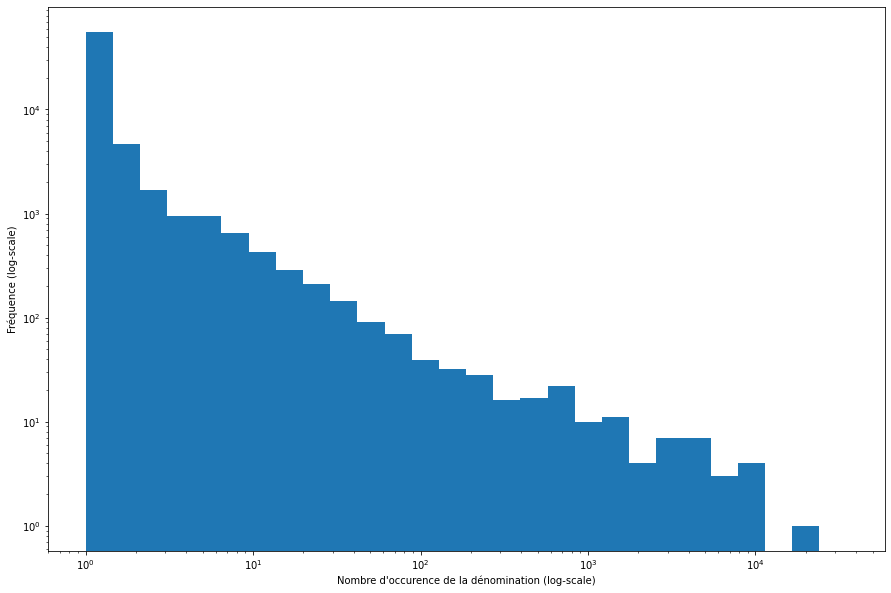

In [274]:
#print(df.groupby('chef_vocation').size().sort_values(ascending=False)[:100])
values = df.groupby('chef_vocation').size().values

logbins = np.geomspace(values.min(), values.max(), 29)
plt.figure(figsize=(15,10))
plt.hist(values, bins=logbins)
plt.semilogx()
plt.semilogy()
plt.xlabel("Nombre d'occurence de la dénomination (log-scale)")
plt.ylabel("Fréquence (log-scale)")
plt.show()

In [98]:
statistics_grouped(df,'chef_vocation')

count    66297.000000
mean         5.272335
std        185.390130
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      34962.000000
dtype: float64

Frequence de chef_vocation
chef_vocation
·                     34962
rentiere              19196
rentier                9996
journalier             9061
menagere               8115
agriculteur            7968
cordonnier             5947
menuisier              5858
journaliere            5573
proprietaire           5352
gociant                5176
manoeuvre              4974
couturiere             4277
charpentier            4251
tailleur               4018
vigneron               3922
jardinier              3468
serrurier              3136
macon                  2846
lingere                2832
cafetier               2822
professeur             2757
tailleuse              2566
fermier                2219
gypsier                2030
employe                2011
commis                 1873
concierge  

We can see that *svocation, s vocation,  sans vocation, sans profession, spvocation* correspond to the same profession.
Furthermore, professions with occurence cout below a 100 contains much more errors.
A solution to that would be only keeping profession with high enough occurence count but that would lead to a loss of data. Another solution would be to manually correct the most frequent profession names per year. 

In [103]:
print_yearly_frequency(df,'chef_vocation')

Most frequent chef_vocation of year 1810
chef_vocation
·                      603
vigneron               163
manoeuvre               86
laboureur               82
rentiere                70
cordonnier              67
marchand                42
charpentier             41
rentier                 40
couturiere              39
jardinier               39
menuisier               36
tailleur                34
journalier              32
agriculteur             29
marchande               29
proprietaire            25
boulanger               24
lingere                 23
macon                   23
serrurier               20
pecheur                 17
fermier                 16
boucher                 15
institutrice            15
masson                  15
perruquier              15
blanchisseuse           14
tailleuse               14
vendeur de vin          14
imprimeur               12
voiturier               12
lavandiere              11
ferblantier              9
fileuse                  9


Most frequent chef_vocation of year 1890
chef_vocation
rentiere           484
·                  428
menagere           395
journalier         220
rentier            188
agriculteur        186
cordonnier         139
gociant            139
couturiere         135
menuisier          130
manoeuvre          117
journaliere         97
professeur          90
employe             88
jardinier           78
cafetier            75
tailleur            74
serrurier           73
charpentier         70
commis              67
gypsier             66
lingere             52
institutrice        51
concierge           49
comptable           48
tanneur             48
proprietaire        47
blanchisseuse       40
emp . postal        36
vigneron            35
tailleuse           34
ferblantier         31
fermier             31
relieur             31
boulanger           30
instituteur         30
macon               29
cocher              28
cafelier            26
coiffeur            26
ingenieur           26
bo

In [153]:
treshold_by_total_occurence(df,'chef_vocation',treshold=20)

Number of unique chef_vocation: 66297
If we only keep names occuring more than 20 times:
We keep 73.21% of the total values
We keep 718 of the unique names


As we can see, by only cleaning the names occuring more than 20 times, we keep almost 3/4 th of the data and have to manually clean around 800 names. 
On the other hand, we can decide to keep the top 100 jobs of each years and only clean that data.

In [154]:
topn = 100
df_frequent = treshold_per_year_occurence(df,'chef_vocation',topn=topn)
print(f'By keeping only the jobs that are in the top {topn} jobs of at least one year:')
print(f'We keep {len(df_frequent)/len(df):.2%} of the data and keep a total of {df_frequent["chef_vocation"].nunique()} unique jobs')

By keeping only the jobs that are in the top 100 jobs of at least one year:
We keep 70.52% of the data and keep a total of 608 unique jobs


#### Chef vocation plot over years
It would be better to plot the percentage of other jobs over the year (after correcting the jobs and only keeping the top n)

##### Tanneur

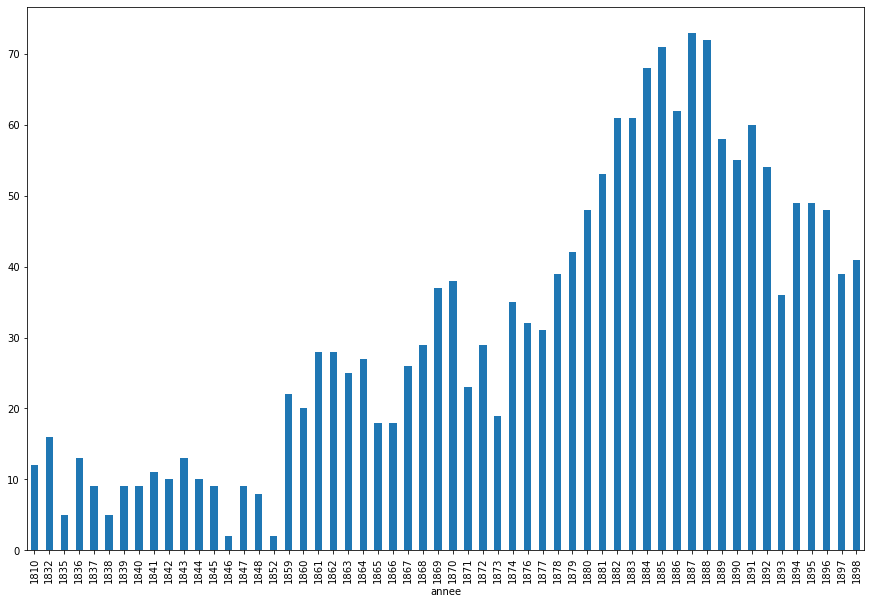

In [186]:
df_plot = df[df['chef_vocation'].str.contains('tanneur')].groupby('annee').size() \
.plot.bar(figsize=(15,10))

##### Vigne

<AxesSubplot:xlabel='annee'>

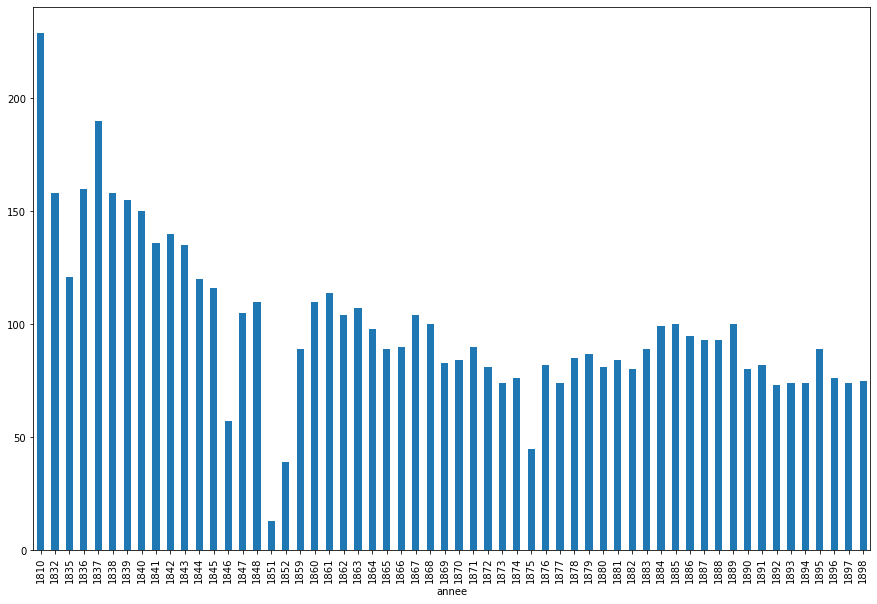

In [185]:
vigne_term = ['vin','vigne','tonnelier','encaveur','viti']
df[df['chef_vocation'].str.contains('|'.join(vigne_term))].groupby('annee').size()\
.plot.bar(figsize=(15,10))

### Data cleaning

In [155]:
df = pd.read_csv(DATA_DIR+'census_reduced.csv')

/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [177]:
df.groupby('chef_vocation').size().nlargest(topn)
df[(df['chef_vocation'].str.contains('vocation')) & ~ (df['chef_vocation'].str.contains('|'))].groupby('chef_vocation').size().nlargest(100)

Series([], dtype: int64)

In [180]:
df[(df['chef_vocation'].str.contains('\|'))].groupby('chef_vocation').size().nlargest(100)

chef_vocation
rentiere|rentiere                        155
agriculteur|agriculteur                   88
rentier|rentiere                          57
·|·                                       57
rentier|rentier                           53
journalier|journalier                     41
professeur|rentiere                       32
proprietaire|proprietaire                 32
rentiere|rentier                          31
gociant|rentiere                          30
vigneron|vigneron                         29
tailleur de|pierres                       25
journaliere|journaliere                   24
employe au|chateau                        22
·|rentiere                                21
maitresse de|pension                      20
menagere|menagere                         20
laboureur|laboureur                       19
manoeuvre|menagere                        17
proprietaire|rentiere                     17
agriculteur|fermier                       15
fermier|agriculteur                      